# Visualize Counts for the three classes  

The number of volume-wise predictions for each of the three classes can be visualized in a 2D-space (with two classes as the axes and the remained or class1-class2 as the value of the third class). Also, the percentage of volume-wise predictions can be shown in a modified pie-chart, i.e. a doughnut plot.

### import modules

In [1]:
import os
import pickle

import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn import svm

import scipy.misc
from scipy import ndimage
from scipy.stats import beta
from PIL import Image

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

sns.set_context('poster')
sns.set_style('ticks')

In [2]:
# after converstion to .py, we can use __file__ to get the module folder
try:
    thisDir = os.path.realpath(__file__)
# in notebook form, we take the current working directory (we need to be in 'notebooks/' for this!)
except:
    thisDir = '.'
# convert relative path into absolute path, so this will work with notebooks and py modules
supDir = os.path.abspath(os.path.join(os.path.dirname(thisDir), '..'))

supDir

'/data/martin/volume-wise-language'

## Outline the WTA prediction model

### make all possible values

In [3]:
def make_all_dummy():
    my_max = 100

    d = {}

    count = 0

    for bi in np.arange(0,my_max+(10**-10),0.5):
        left_and_right = my_max - bi

        for left in np.arange(0,left_and_right+(10**-10),0.5):
            right = left_and_right-left
            d[count] = {'left':left,'bilateral':bi,'right':right}
            count+=1

    df = pd.DataFrame(d).T

    assert np.unique(df.sum(axis=1))[-1] == my_max
    
    df['pred'] = df.idxmax(axis=1)
    
    return df

In [4]:
dummy_df = make_all_dummy()

In [5]:
dummy_df.tail()

,bilateral,left,right,pred
20296,99.0,0.5,0.5,bilateral
20297,99.0,1.0,0.0,bilateral
20298,99.5,0.0,0.5,bilateral
20299,99.5,0.5,0.0,bilateral
20300,100.0,0.0,0.0,bilateral


### transform labels into numbers

In [6]:
my_labeler = preprocessing.LabelEncoder()
my_labeler.fit(['left','bilateral','right','inconclusive'])

LabelEncoder()

In [7]:
my_labeler.classes_

array(['bilateral', 'inconclusive', 'left', 'right'], dtype='<U12')

### 2d space where highest number indiciates class membership (WTA)

In [8]:
def make_dummy_space(dummy_df):
    
    space_df = dummy_df.copy()
    space_df['pred'] = my_labeler.transform(dummy_df['pred'])
    
    space_df.index = [space_df.left, space_df.right]
    space_df = space_df[['pred']]
    space_df = space_df.unstack(1)['pred']
    
    return space_df

In [9]:
dummy_space_df = make_dummy_space(dummy_df)

In [10]:
dummy_space_df.tail()

right,0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,...,95.5,96.0,96.5,97.0,97.5,98.0,98.5,99.0,99.5,100.0
left,,,,,,,,,,,,,,,,,,,,,
98.0,2.0,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98.5,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### define color map

In [11]:
colors_file = os.path.join(supDir,'models','colors.p')
with open(colors_file, 'rb') as f:
    color_dict = pickle.load(f)

my_cols = {}
for i, j in zip(['red','yellow','blue','trans'], ['left','bilateral','right','inconclusive']):
    my_cols[j] = color_dict[i]

my_col_order = np.array([my_cols[g] for g in my_labeler.classes_])

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", my_col_order)

### plot WTA predictions

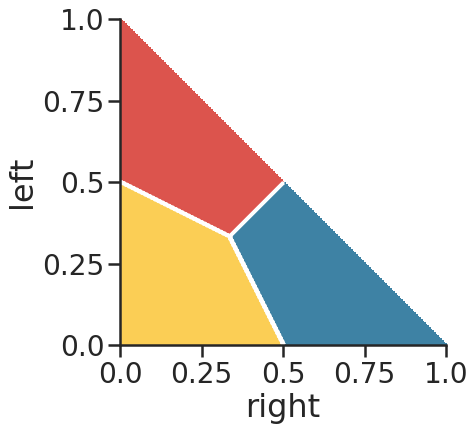

In [12]:
plt.figure(figsize=(6,6))
plt.imshow(dummy_space_df, origin='image',cmap=cmap,extent=(0,100,0,100),alpha=0.8)
plt.contour(dummy_space_df[::-1],colors='white',alpha=1,origin='image',extent=(0,100,0,100),antialiased=True)
plt.xlabel('right',fontsize=32)
plt.xticks(range(0,101,25),np.arange(0,1.01,.25),fontsize=28)
plt.yticks(range(0,101,25),np.arange(0,1.01,.25),fontsize=28)
plt.ylabel('left',fontsize=32)
sns.despine()
plt.show()

### load data

In [13]:
groupdata_filename = '../data/processed/csv/withinconclusive_prediction_df.csv'
prediction_df = pd.read_csv(groupdata_filename,index_col=[0,1],header=0)

#### toolbox use

In [14]:
#groupdata_filename = os.path.join(supDir,'models','withinconclusive_prediction_df.csv')
#prediction_df = pd.read_csv(groupdata_filename,index_col=[0,1],header=0)

In [ ]:
prediction_df.tail()

### show data and WTA space

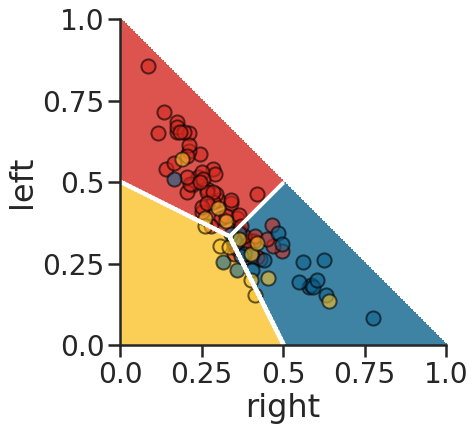

In [16]:
plt.figure(figsize=(6,6))

plt.imshow(dummy_space_df, origin='image',cmap=cmap,extent=(0,100,0,100),alpha=0.8)
plt.contour(dummy_space_df[::-1],colors='white',alpha=1,origin='image',extent=(0,100,0,100),antialiased=True)

for c in ['left','right','bilateral']:
    a_df = prediction_df.loc[c,['left','right']] * 100
    plt.scatter(a_df['right'],a_df['left'],c=[my_cols[c]],edgecolor='k',linewidth=2,s=200,alpha=0.6)

plt.xlabel('right',fontsize=32)
plt.xticks(range(0,101,25),np.arange(0,1.01,.25),fontsize=28)
plt.yticks(range(0,101,25),np.arange(0,1.01,.25),fontsize=28)
plt.ylabel('left',fontsize=32)
sns.despine()

plt.savefig('../reports/figures/14-prediction-space.png',dpi=300,bbox_inches='tight')

plt.show()

## show one patient's data

### doughnut plot

In [17]:
p_name = 'pat###'

In [ ]:
p_count_df = pd.read_csv('../data/processed/csv/%s_counts_df.csv'%p_name,index_col=[0,1],header=0)
p_count_df

In [19]:
def make_donut(p_count_df, ax, my_cols=my_cols):
    """show proportion of the number of volumes correlating highest with one of the three groups"""

    percentages = p_count_df/p_count_df.sum(axis=1).values[-1] * 100

    ## donut plot visualization adapted from https://gist.github.com/krishnakummar/ad00d05311977732764f#file-donut-example-py
    ax.pie(
        percentages.values[-1],
        pctdistance=0.75,
        colors=[my_cols[x] for x in percentages.columns],
        autopct='%0.0f%%',
        shadow=False,
        textprops={'fontsize': 40})

    centre_circle = plt.Circle((0, 0), 0.55, fc='white')
    ax.add_artist(centre_circle)
    ax.set_aspect('equal')
    return ax

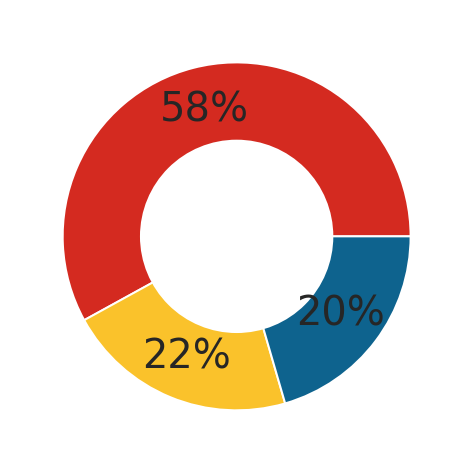

In [20]:
fig,ax = plt.subplots(1,1,figsize=(8,8))
ax = make_donut(p_count_df,ax)
plt.savefig('../examples/%s_donut.png'%p_name,dpi=300,bbox_inches='tight')
plt.show()

### prediction space

In [21]:
def make_pred_space(p_count_df, prediction_df, ax, dummy_space_df=dummy_space_df):

    ax.imshow(dummy_space_df, origin='image',cmap=cmap,extent=(0,100,0,100),alpha=0.8)
    ax.contour(dummy_space_df[::-1],colors='white',alpha=1,origin='image',extent=(0,100,0,100),antialiased=True)

    for c in ['left','right','bilateral']:
        a_df = prediction_df.loc[c,['left','right']] * 100
        ax.scatter(a_df['right'],a_df['left'],c=[my_cols[c]],edgecolor='k',linewidth=2,s=200,alpha=0.6)

    percentages = p_count_df/p_count_df.sum(axis=1).values[-1] * 100
    y_pred = percentages.idxmax(axis=1).values[-1]
    ax.scatter(percentages['right'],percentages['left'],c=[my_cols[y_pred]],edgecolor='white',linewidth=4,s=1500,alpha=1)

    plt.xlabel('right',fontsize=32)
    plt.xticks(range(0,101,25),np.arange(0,1.01,.25),fontsize=28)
    plt.yticks(range(0,101,25),np.arange(0,1.01,.25),fontsize=28)
    plt.ylabel('left',fontsize=32)

    sns.despine()

    return ax

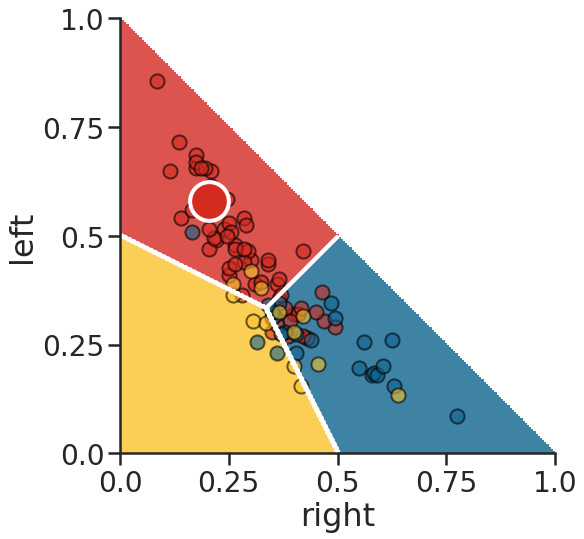

In [22]:
fig,ax = plt.subplots(1,1,figsize=(8,8))
ax = make_pred_space(p_count_df,prediction_df,ax)
plt.savefig('../examples/%s_predSpace.png'%p_name,dpi=300,bbox_inches='tight')    
plt.show()

#### toolbox use

In [23]:
#def make_p(pFolder,pName,prediction_df=prediction_df):
#    
#    count_filename = os.path.join(pFolder,''.join([pName,'_counts_df.csv']))
#    p_count_df = pd.read_csv(count_filename,index_col=[0,1],header=0)  
#
#    fig = plt.figure(figsize=(8,8))
#    ax = plt.subplot(111)
#    ax = make_donut(p_count_df,ax)
#    out_name_donut = os.path.join(pFolder,''.join([pName,'_donut.png']))
#    plt.savefig(out_name_donut,dpi=300,bbox_inches='tight')
#    plt.close()
#
#    fig = plt.figure(figsize=(8,8))
#    with sns.axes_style("ticks"):
#        ax = plt.subplot(111)
#        ax = make_pred_space(p_count_df,prediction_df,ax)
#    out_name_space = os.path.join(pFolder,''.join([pName,'_predSpace.png']))
#    plt.savefig(out_name_space,dpi=300,bbox_inches='tight') 
#    plt.close()
#    
#    return out_name_donut, out_name_space

### summary

The prediction space allows to see the results on the group level. If used in an application on the level of N=1, the value of the patient of interest in relation to the rest of the group can be seen. If one is interested in the precise numbers, scaled to sum up to 100%, the doughnut plot supplements the prediction space plot in this regard.



**************

< [Previous](13-mw-make-group-predictions.ipynb) | [Contents](00-mw-overview-notebook.ipynb) | [Next >](15-mw-visualize-logistic-regression.ipynb)